In [1]:
#svm_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#5 July 2018
#
#train an svm model on the XO dataset, this executes in about 10 minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate smallish sample training data...so that model hyperparameters can be tuned quickly
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,-1.834591,-0.972246,2.076292,-2.654271,O,0.0,1.0,0.0
19996,19996,-4.877253,-0.941386,4.967273,-2.950922,B,0.0,0.0,1.0
19997,19997,-3.925957,8.497939,9.360989,2.003576,B,0.0,0.0,1.0
19998,19998,-5.713137,3.886965,6.910024,2.544173,B,0.0,0.0,1.0
19999,19999,2.797994,1.273026,3.073982,0.426986,B,0.0,0.0,1.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

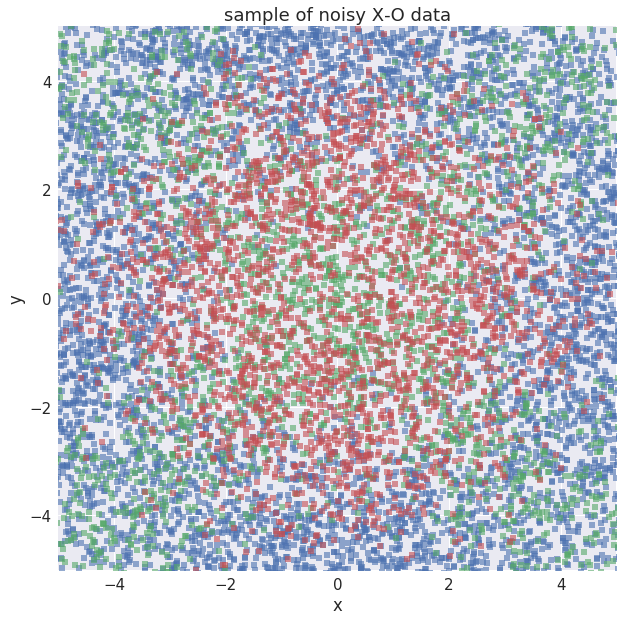

In [6]:
#scatterplot of noisy training data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/training_data.png')

In [7]:
#check class balance
cols = ['id', 'class']
N = train[cols].groupby('class').count().sort_values('id')
N

,id
class,
O,2580
X,2642
B,14778


In [8]:
#rebalance training data
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
train_balanced[cols].groupby('class').count()

,id
class,
B,2580
O,2580
X,2642


In [9]:
#get features x and target variable y
x_cols = ['x', 'y']
y_col = 'class'
x = train_balanced[x_cols]
y = train_balanced[y_col]

In [10]:
#grid-search across hyperparameters, executed in parallel on all available cpus (4 cpus on m4.xlarge)
#this takes 5 minutes, and executes more slowly when gamma>>1
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
gammas = [0.01, 0.1, 1.0, 10.0]
hperparameters = {'C':Cs, 'gamma':gammas}
model_grid = GridSearchCV(model, hperparameters, verbose=-1, n_jobs=-1).fit(x, y) #set verbose=2 when debugging

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.0min finished


In [11]:
#GridSearchCV's recommended model and hyperparameters
best_params_ = model_grid.best_params_
C = best_params_['C']
gamma =  best_params_['gamma']
best_score = model_grid.best_score_
print best_score
print best_params_
print C, gamma
#model_grid.cv_results_

0.6705972827480133
{'C': 0.1, 'gamma': 1.0}
0.1 1.0


In [12]:
#now train SVC model on 5x larger dataset
N_dots *= 5
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
print train.shape
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
print train_balanced[cols].groupby('class').count()
x = train_balanced[x_cols]
y = train_balanced[y_col]
model = SVC(kernel='rbf', C=C, gamma=gamma, probability=True).fit(x, y)

(100000, 9)
          id
class       
B      12635
O      12635
X      13486


In [13]:
#generate predictions on testing dataset
N_dots = 20000
test = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = test[x_cols]
test['class_pred'] = model.predict(x)
test.head()

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-5.254024,4.725624,7.066561,2.409093,B,0.0,0.0,1.0,X
1,1,5.892758,2.766923,6.510028,0.438989,B,0.0,0.0,1.0,B
2,2,-0.752087,10.046018,10.074131,1.645521,B,0.0,0.0,1.0,B
3,3,-6.057100,-3.361307,6.927254,-2.634967,B,0.0,0.0,1.0,B
4,4,6.649808,3.548175,7.537207,0.490146,B,0.0,0.0,1.0,B


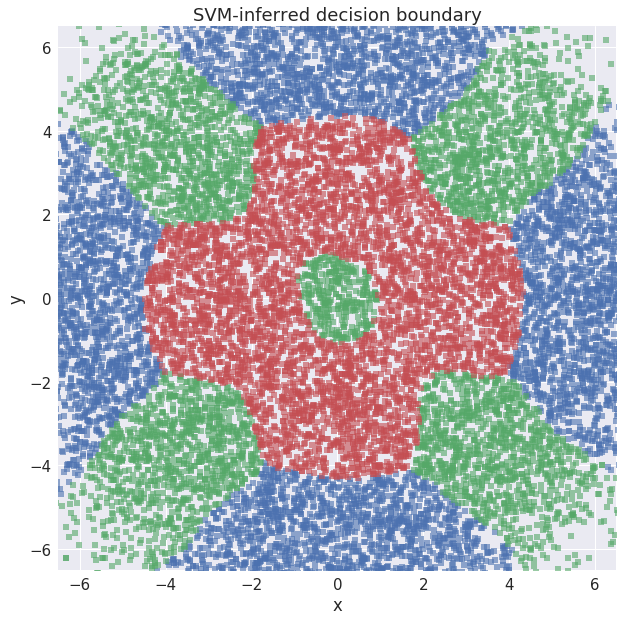

In [14]:
#scatterplot showing model's predicted decision boundaries
df = test
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('SVM-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/svm_decision_boundary.png')

In [15]:
#model accuracy
idx = (test['class'] == test['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.691


In [16]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  12.0161235491
